# Estudo de Distribuição de Autovalores em Canais RIS via Simulação de Monte Carlo

Este notebook realiza uma simulação de Monte Carlo para estimar a distribuição dos autovalores da matriz de correlação espacial $\mathbf{R}$ de uma Superfície Inteligente Reconfigurável (RIS).  
A metodologia e as análises foram baseadas no artigo **"Rayleigh Fading Modeling and Channel Hardening for Reconfigurable Intelligent Surfaces"**, publicado na *IEEE Wireless Communications Letters*.



### 1. Importação de Bibliotecas

In [6]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt

### 2. Definição de Parâmetros

In [11]:
# Parâmetros da simulação
lambda_ = 1  # Comprimento de onda
plane_waves = 100  # Número de ondas planas por amostra
amostras = 5000  # Número de amostras de Monte Carlo
N_HV = 40  # Número de elementos em cada dimensão do RIS (horizontal e vertical)
N = N_HV ** 2  # Número total de elementos
d_values = [lambda_ / 8, lambda_ / 4, lambda_ / 2]  # Espaçamentos considerados

# Pré-alocação da matriz para armazenar autovalores
autovalores_R = np.zeros((N, len(d_values)))

### 3. Função de Amostragem de Ângulos

In [12]:
def sample_angles(n):
    """
    Amostra n pares de ângulos (phi, theta) na esfera unitária
    de acordo com a distribuição isotrópica especificada no artigo.
    """
    phi = np.pi * (np.random.rand(n) - 0.5)
    theta = np.arcsin(2 * np.random.rand(n) - 1)
    return phi, theta

### 4. Simulação de Monte Carlo

In [13]:
# Loop para cada valor de espaçamento 'd'
for idx, d in enumerate(d_values):
    # Construção da grade de posições
    grid_points = np.arange(N_HV) * d
    X, Y = np.meshgrid(grid_points, grid_points)
    locations = np.stack((X.flatten(), Y.flatten(), np.zeros(N)), axis=1)

    # Inicialização da matriz H
    H = np.zeros((N, amostras), dtype=complex)

    # Simulação de Monte Carlo
    for s in range(amostras):
        h = np.zeros(N, dtype=complex)
        phi, theta = sample_angles(plane_waves)

        for l in range(plane_waves):
            k = (2 * np.pi / lambda_) * np.array([
                np.cos(theta[l]) * np.cos(phi[l]),
                np.cos(theta[l]) * np.sin(phi[l]),
                np.sin(theta[l])
            ])
            a = np.exp(1j * locations @ k)
            h += (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2) * a / np.sqrt(plane_waves)

        H[:, s] = h

    # Estimativa da matriz de correlação
    R_hat = (1 / amostras) * (H @ H.conj().T)
    autovalores_R[:, idx] = np.sort(np.linalg.eigvalsh(R_hat))[::-1]

### 5. Plotagem dos Resultados

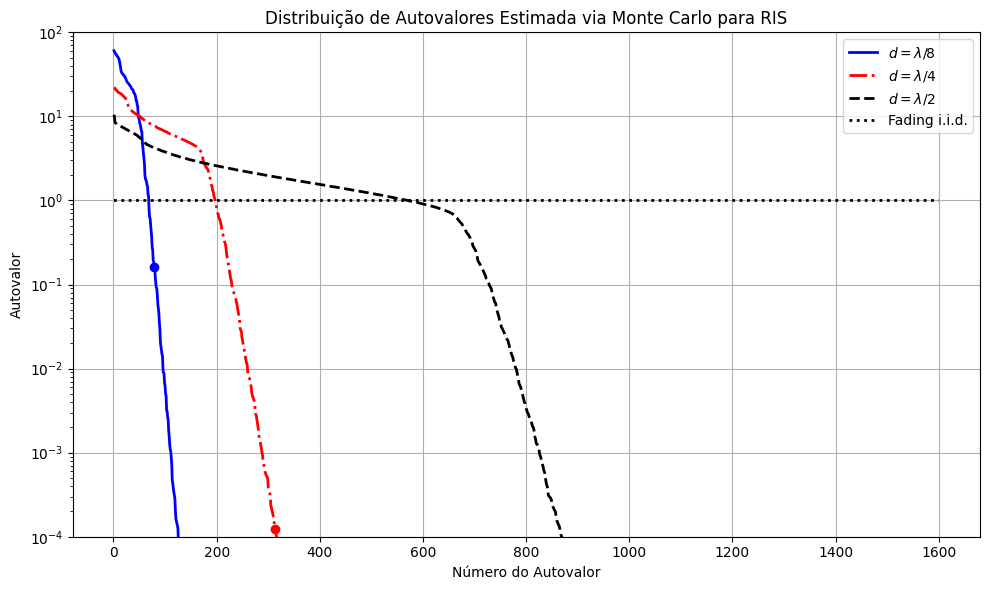

In [14]:
# Configurações de plot
plt.figure(figsize=(10, 6))
colors = ['b', 'r', 'k']
styles = ['-', '-.', '--']

# Plot dos autovalores
for idx in range(len(d_values)):
    plt.plot(
        np.arange(1, N + 1),
        autovalores_R[:, idx],
        styles[idx],
        color=colors[idx],
        linewidth=2
    )

# Linha de referência para fading i.i.d.
plt.plot(
    np.arange(1, N + 1),
    np.ones(N),
    'k:',
    linewidth=2,
    label='Fading i.i.d.'
)

# Marcação dos ranks estimados
for idx, d in enumerate(d_values):
    rank_est = round(np.pi * (N_HV * d) ** 2)
    plt.plot(
        rank_est,
        autovalores_R[rank_est - 1, idx],
        colors[idx] + 'o',
        linewidth=2
    )

# Configurações finais do gráfico
plt.yscale('log')
plt.ylim([1e-4, 1e2])
plt.xlabel('Número do Autovalor')
plt.ylabel('Autovalor')
plt.legend([r'$d=\lambda/8$', r'$d=\lambda/4$', r'$d=\lambda/2$', 'Fading i.i.d.'])
plt.grid(True)
plt.title('Distribuição de Autovalores Estimada via Monte Carlo para RIS')
plt.tight_layout()
plt.show()


### 6. Cálculo da Fração da Energia Capturada (Rank Efetivo)

In [15]:
# Cálculo da Fração da Energia Capturada até o Rank Efetivo

# Lista para armazenar as frações de energia capturadas para cada valor de d
frac_energia = []

# Loop sobre cada valor de espaçamento d
for idx, d in enumerate(d_values):
    # Estimativa do rank efetivo baseado no artigo (πNA/λ²)
    rank_est = round(np.pi * (N_HV * d) ** 2)

    # Energia total considerando todos os autovalores
    energia_total = np.sum(autovalores_R[:, idx])

    # Energia acumulada até o rank estimado
    energia_rank_est = np.sum(autovalores_R[:rank_est, idx])

    # Cálculo da fração de energia
    fracao = energia_rank_est / energia_total
    frac_energia.append(fracao)

    # Impressão dos resultados
    print(f"Para d = {d/lambda_:.2f}λ, o rank efetivo captura {fracao*100:.2f}% da energia.")


Para d = 0.12λ, o rank efetivo captura 99.94% da energia.
Para d = 0.25λ, o rank efetivo captura 100.00% da energia.
Para d = 0.50λ, o rank efetivo captura 100.00% da energia.


### 7. Plot da Energia Cumulativa dos Autovalores

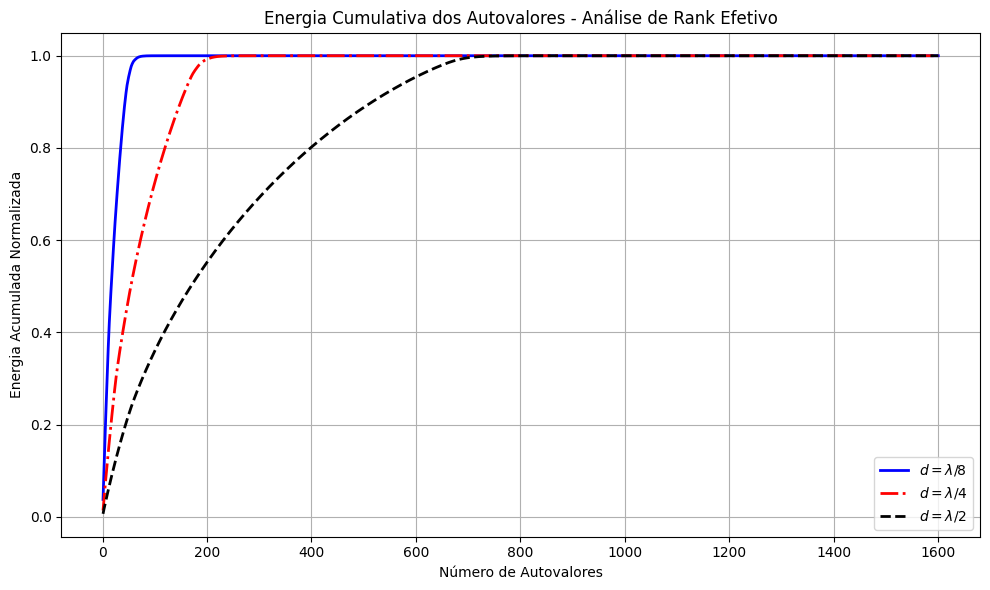

In [16]:
# Plot da Energia Cumulativa dos Autovalores Normalizados

# Configuração da figura
plt.figure(figsize=(10, 6))

# Loop para cada valor de espaçamento d
for idx, d in enumerate(d_values):
    # Cálculo da energia cumulativa normalizada
    energia_cumulativa = np.cumsum(autovalores_R[:, idx])
    energia_cumulativa /= energia_cumulativa[-1]  # Normalização para 1

    # Plot da energia cumulativa
    plt.plot(
        np.arange(1, N + 1),
        energia_cumulativa,
        styles[idx],
        color=colors[idx],
        linewidth=2,
        label=fr'$d=\lambda/{int(lambda_/d)}$'
    )

# Configurações do gráfico
plt.xlabel('Número de Autovalores')
plt.ylabel('Energia Acumulada Normalizada')
plt.grid(True)
plt.legend()
plt.title('Energia Cumulativa dos Autovalores - Análise de Rank Efetivo')
plt.tight_layout()
plt.show()

### 8. Simulação do Hardening de SNR para Diferentes Espaçamentos 𝑑

In [17]:
# Simulação de Hardening de Canal: Análise da SNR Normalizada (SNR/N²)

# Parâmetros da simulação de hardening
N_vals = np.arange(10, 401, 10)  # Número de elementos de 10 até 400
plane_waves_hardening = 100  # Número de ondas planas para hardening
amostras_hardening = 1000  # Número de amostras para cada valor de N

# Dicionário para armazenar os resultados de SNR para cada valor de d
snr_results = {d: [] for d in d_values}

# Loop sobre cada valor de espaçamento d
for d in d_values:
    # Loop sobre diferentes quantidades de elementos N
    for N_local in N_vals:
        # Construção da grade de posições do RIS
        grid_points = np.arange(int(np.sqrt(N_local))) * d
        X, Y = np.meshgrid(grid_points, grid_points)
        locations = np.stack((X.flatten(), Y.flatten(), np.zeros(X.size)), axis=1)

        # Lista para armazenar as SNRs simuladas para cada amostra
        snrs = []

        # Simulação de Monte Carlo
        for _ in range(amostras_hardening):
            phi, theta = sample_angles(plane_waves_hardening)
            h1 = np.zeros(X.size, dtype=complex)
            h2 = np.zeros(X.size, dtype=complex)

            for l in range(plane_waves_hardening):
                k = (2 * np.pi / lambda_) * np.array([
                    np.cos(theta[l]) * np.cos(phi[l]),
                    np.cos(theta[l]) * np.sin(phi[l]),
                    np.sin(theta[l])
                ])
                a = np.exp(1j * locations @ k)
                h1 += (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2) * a / np.sqrt(plane_waves_hardening)
                h2 += (np.random.randn() + 1j * np.random.randn()) / np.sqrt(2) * a / np.sqrt(plane_waves_hardening)

            # Cálculo da SNR instantânea como quadrado do produto interno
            snr_inst = np.abs(np.sum(h1 * h2)) ** 2
            snrs.append(snr_inst)

        # Média da SNR normalizada por N²
        snr_medio_normalizado = np.mean(snrs) / (N_local ** 2)
        snr_results[d].append(snr_medio_normalizado)


### 9. Plot da SNR Normalizada para Diferentes Espaçamentos 𝑑


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
C:\Users\barbararosa\AppData\Local\Temp\ipykernel_11392\4290290606.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('SNR Normalizada ($\mathrm{SNR}/N^2$)')


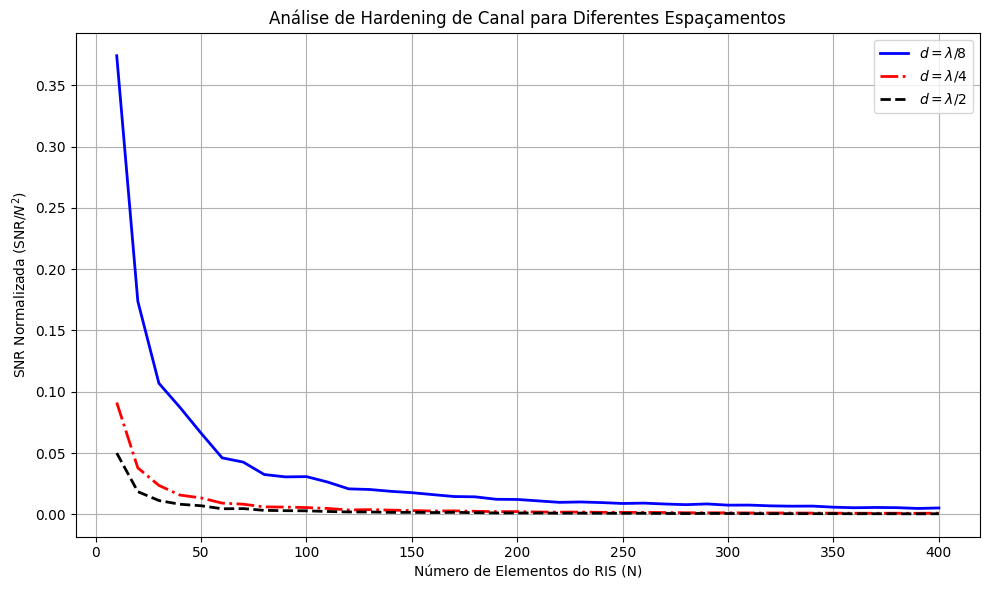

In [18]:
# Plot da SNR Normalizada (Hardening do Canal)

# Configuração da figura
plt.figure(figsize=(10, 6))

# Loop para plotar os resultados de cada valor de espaçamento d
for idx, d in enumerate(d_values):
    plt.plot(
        N_vals,
        snr_results[d],
        styles[idx],
        color=colors[idx],
        linewidth=2,
        label=fr'$d=\lambda/{int(lambda_/d)}$'
    )

# Configurações do gráfico
plt.xlabel('Número de Elementos do RIS (N)')
plt.ylabel('SNR Normalizada ($\mathrm{SNR}/N^2$)')
plt.grid(True)
plt.legend()
plt.title('Análise de Hardening de Canal para Diferentes Espaçamentos')
plt.tight_layout()
plt.show()